## Twitter Sentiment Analysis 

### Part 3: Naive Bayes

The usual data-science workflow is to quickly train and evaluate several models before any further work (such as feature extraction) and with no hyperparameter tuning to select a few choice models for further work.

Since I'm running the project on a home laptop and have limited time, I'm going to start just by focusing on Naive Bayes, which trains fast. Next steps would be single decisions trees.

### Load Pre-Processed Data

The timer decorator comes from Geir Arne Hjelle's [Real Python Tutorial](https://realpython.com/python-timer/#using-the-python-timer-decorator).

In [1]:
import os 
import time
import functools
import numpy as np
import scipy.sparse as sp

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [2]:
dirpath = os.path.join("..","data","3_processed","sentiment140")
filenames = ['X_text_bow'
            ,'X_tokn_bow'
            ,'X_filt_bow'
            ,'X_stem_bow'
            ,'X_lemm_bow'
            ,'X_text_tfidf'
            ,'X_tokn_tfidf'
            ,'X_filt_tfidf'
            ,'X_stem_tfidf'
            ,'X_lemm_tfidf'
            ,'X_text_log_tfidf'
            ,'X_tokn_log_tfidf'
            ,'X_filt_log_tfidf'
            ,'X_stem_log_tfidf'
            ,'X_lemm_log_tfidf']

filepaths = [os.path.join(dirpath, ''.join([filename, '.npz'])) for filename in filenames]

In [3]:
# load pre-processed featre vectors
@timer
def load_data():
    X_text_bow       = sp.load_npz(filepaths[0])
    X_tokn_bow       = sp.load_npz(filepaths[1])
    X_filt_bow       = sp.load_npz(filepaths[2])
    X_stem_bow       = sp.load_npz(filepaths[3])
    X_lemm_bow       = sp.load_npz(filepaths[4])
    X_text_tfidf     = sp.load_npz(filepaths[5])
    X_tokn_tfidf     = sp.load_npz(filepaths[6])
    X_filt_tfidf     = sp.load_npz(filepaths[7])
    X_stem_tfidf     = sp.load_npz(filepaths[8])
    X_lemm_tfidf     = sp.load_npz(filepaths[9])
    X_text_log_tfidf = sp.load_npz(filepaths[10])
    X_tokn_log_tfidf = sp.load_npz(filepaths[11])
    X_filt_log_tfidf = sp.load_npz(filepaths[12])
    X_stem_log_tfidf = sp.load_npz(filepaths[13])
    X_lemm_log_tfidf = sp.load_npz(filepaths[14])
    
    return (  X_text_bow      
            , X_tokn_bow      
            , X_filt_bow      
            , X_stem_bow  
            , X_lemm_bow
            , X_text_tfidf    
            , X_tokn_tfidf    
            , X_filt_tfidf    
            , X_stem_tfidf  
            , X_lemm_tfidf
            , X_text_log_tfidf
            , X_tokn_log_tfidf
            , X_filt_log_tfidf
            , X_stem_log_tfidf
            , X_lemm_log_tfidf
            )

In [4]:
( X_text_bow      
, X_tokn_bow      
, X_filt_bow      
, X_stem_bow  
, X_lemm_bow
, X_text_tfidf    
, X_tokn_tfidf    
, X_filt_tfidf    
, X_stem_tfidf  
, X_lemm_tfidf
, X_text_log_tfidf
, X_tokn_log_tfidf
, X_filt_log_tfidf
, X_stem_log_tfidf
, X_lemm_log_tfidf
) = load_data()

Elapsed time: 23.2331 seconds


In [5]:
# load y target vector
y = np.load(os.path.join(dirpath, 'y.npy'))

---

### Train Classifiers

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.show()
    
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(6, 4))
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.show()
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.show()

In [8]:
X_text_bow.shape, X_tokn_bow.shape, X_filt_bow.shape, X_stem_bow.shape, X_lemm_bow.shape

((1565203, 682284),
 (1565203, 749735),
 (1565203, 749713),
 (1565203, 689961),
 (1565203, 736764))

### Naive Bayes

In [9]:
# instantiate classifier
NB_clf = MultinomialNB()

Since the NB classifier is fast, we can perform CV across the entire dataset.

In [10]:
@timer
def plot_cv_results(clf, X, y, Xname, cv=5, scoring='accuracy', ylim=[.7, .8]):
    """Line plot of CV results for a given metric.
       Args:
           clf: pre-trained classifier
           X: sparse matrix of features
           y: target vector
           Xname: name of sparse matrix for title
           cv: number of cv folds
           scoring: evaluation metric
                    see sklearn.metrics.SCORERS.keys()
           ylim: range for y-axis limits
    """
    cv_res = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
    mn_res = np.mean(cv_res)
    
    xs = []
    for x in range(cv):
        xs.append(str(x+1))
        
    fig = plt.figure(figsize=(8, 4))   
    plt.plot(xs, cv_res, 'b--', linewidth=.8, label=scoring)
    plt.axhline(y=mn_res, color='r', linestyle='-', linewidth=.5, 
                label=' '.join(["mean",scoring]))
    plt.title(''.join(["CV results - ", Xname]), fontsize=16)
    plt.xlabel("CV folds", fontsize=14)
    plt.ylabel(scoring, fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.ylim(ylim)
    plt.show()

@timer
def plot_mean_cv_results(clf, Xs, y, Xnames, cv=5, scoring='accuracy', ylim=[.7, .8]):
    """Line plot of CV mean results for a given metric, highlighting top mean.
       Args:
           clf: pre-trained classifier
           Xs: preprocesed doc-term sparse matrices
           y: target vector
           Xnames: names of sparse matrices
           cv: number of cv folds
           scoring: evaluation metric
                    see sklearn.metrics.SCORERS.keys()
           ylim: range for y-axis limits
    """
    mean_accuracies = []
    for X in Xs:
        mean_acc = np.mean(cross_val_score(clf, X, y, cv=cv, scoring=scoring))
        mean_accuracies.append(mean_acc)

    max_acc = max(mean_accuracies)
    marker_on = [i for i, val in enumerate(mean_accuracies) if val == max_acc]

    fig = plt.figure(figsize=(10, 6))
    plt.plot(Xnames, mean_accuracies, '-gD', linewidth=.8, 
             label=' '.join(["top mean", scoring]), markevery=marker_on)
    plt.title("CV results", fontsize=16)
    plt.xlabel("vectorization method", fontsize=14)
    plt.ylabel(' '.join(["mean", scoring]), fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.xticks(rotation=90)
    plt.ylim(ylim)
    plt.show()

In [11]:
Xnames = filenames
Xs = [ X_text_bow      
     , X_tokn_bow      
     , X_filt_bow      
     , X_stem_bow  
     , X_lemm_bow
     , X_text_tfidf    
     , X_tokn_tfidf    
     , X_filt_tfidf    
     , X_stem_tfidf  
     , X_lemm_tfidf
     , X_text_log_tfidf
     , X_tokn_log_tfidf
     , X_filt_log_tfidf
     , X_stem_log_tfidf
     , X_lemm_log_tfidf]

#### Accuracy

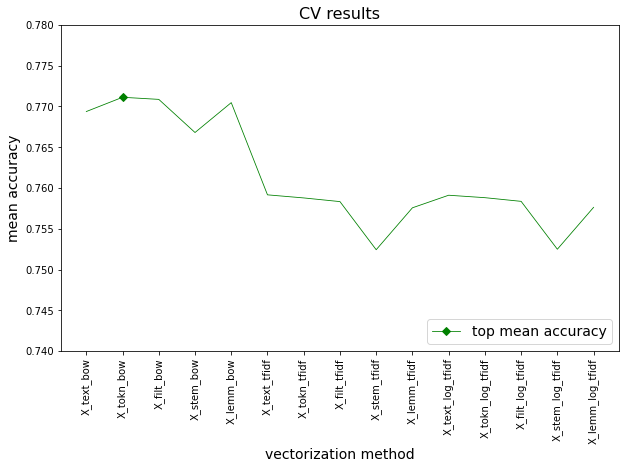

Elapsed time: 38.2897 seconds


In [12]:
plot_mean_cv_results(NB_clf, Xs, y, Xnames, ylim=[.74,.78])

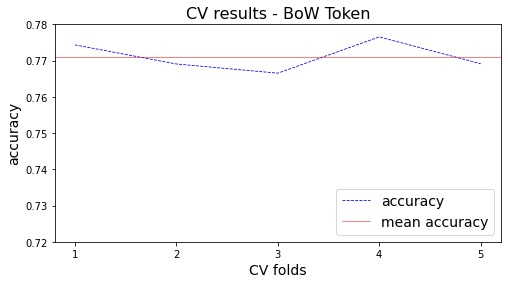

Elapsed time: 2.7121 seconds


In [13]:
plot_cv_results(NB_clf, X_tokn_bow, y, 'BoW Token', ylim=[.72,.78])

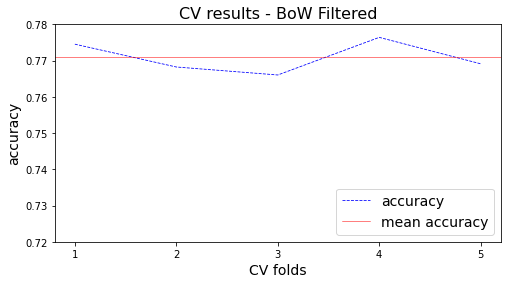

Elapsed time: 2.5466 seconds


In [14]:
plot_cv_results(NB_clf, X_filt_bow, y, 'BoW Filtered', ylim=[.72,.78])

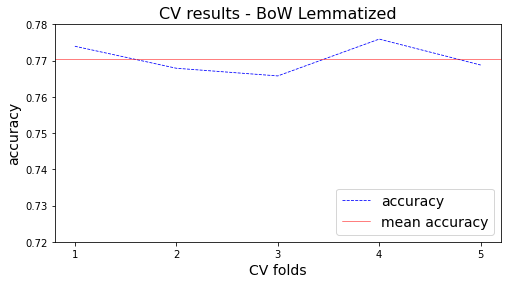

Elapsed time: 2.5309 seconds


In [15]:
plot_cv_results(NB_clf, X_lemm_bow, y, 'BoW Lemmatized', ylim=[.72,.78])

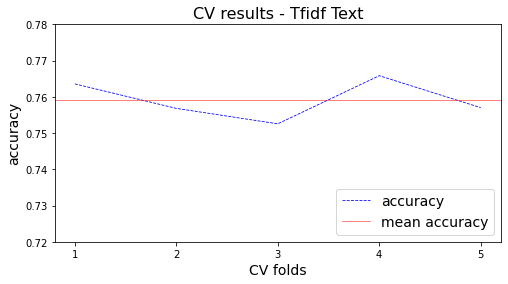

Elapsed time: 2.7046 seconds


In [16]:
# check Tfidf for comparison
plot_cv_results(NB_clf, X_text_tfidf, y, 'Tfidf Text', ylim=[.72,.78])

#### Recall

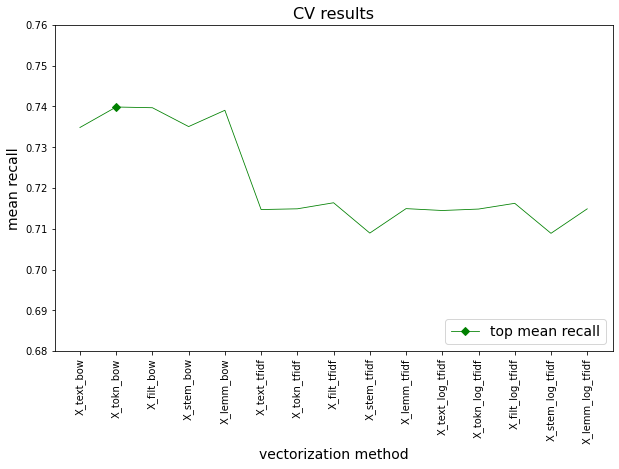

Elapsed time: 43.6582 seconds


In [17]:
plot_mean_cv_results(NB_clf, Xs, y, filenames, scoring='recall', ylim=[.68,.76])

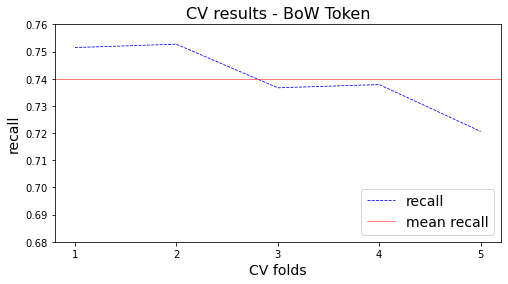

Elapsed time: 3.1231 seconds


In [18]:
plot_cv_results(NB_clf, X_tokn_bow, y, 'BoW Token', scoring='recall', ylim=[.68,.76])

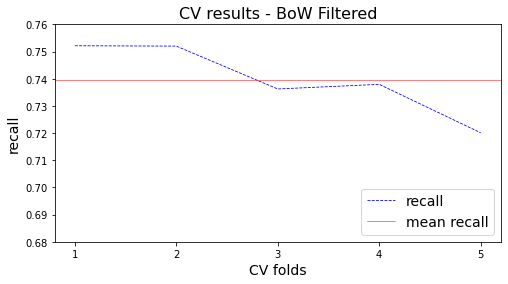

Elapsed time: 2.9093 seconds


In [19]:
plot_cv_results(NB_clf, X_filt_bow, y, 'BoW Filtered', scoring='recall', ylim=[.68,.76])

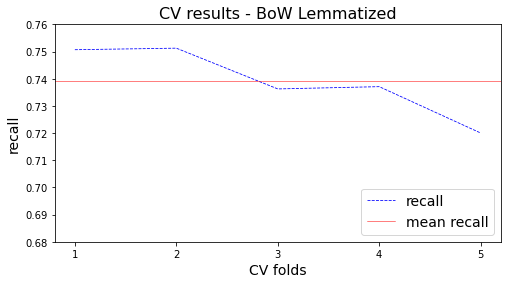

Elapsed time: 2.8958 seconds


In [20]:
plot_cv_results(NB_clf, X_lemm_bow, y, 'BoW Lemmatized', scoring='recall', ylim=[.68,.76])

#### F1 score

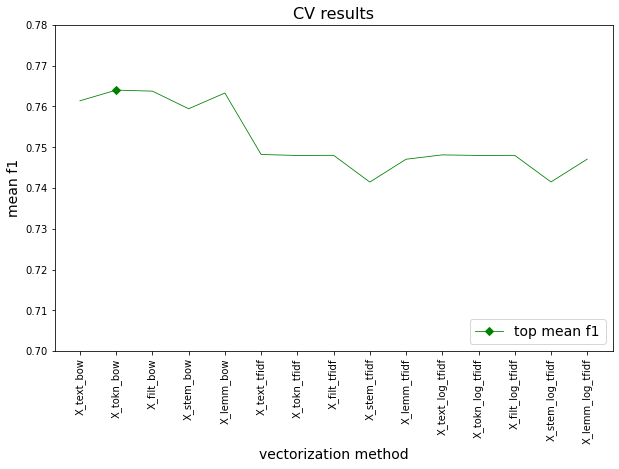

Elapsed time: 43.3786 seconds


In [21]:
plot_mean_cv_results(NB_clf, Xs, y, filenames, scoring='f1', ylim=[.70,.78])

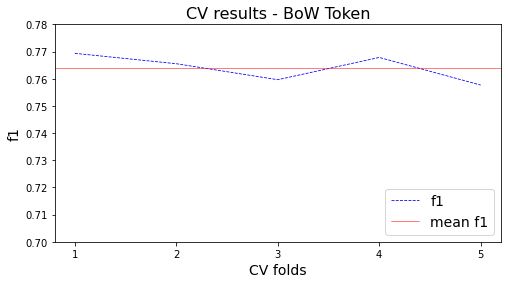

Elapsed time: 3.5732 seconds


In [22]:
plot_cv_results(NB_clf, X_tokn_bow, y, 'BoW Token', scoring='f1', ylim=[.70,.78])

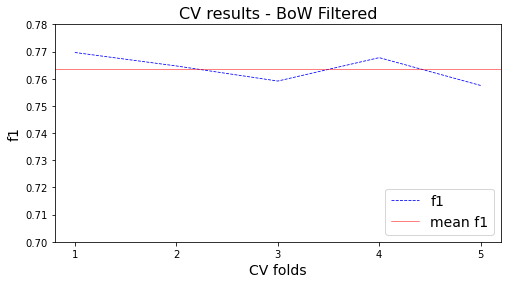

Elapsed time: 3.0594 seconds


In [23]:
plot_cv_results(NB_clf, X_filt_bow, y, 'BoW Filtered', scoring='f1', ylim=[.70,.78])

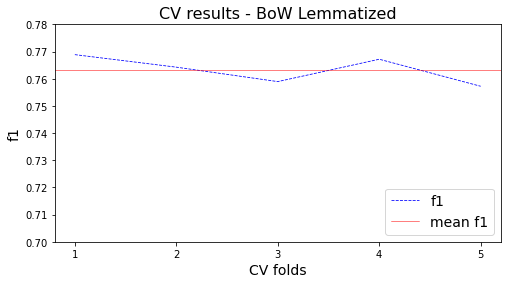

Elapsed time: 2.8824 seconds


In [24]:
plot_cv_results(NB_clf, X_lemm_bow, y, 'BoW Lemmatized', scoring='f1', ylim=[.70,.78])

For Naive Bayes, the BoW tokenized, filtered, or lemmatized versions have the best qualities overall.

#### Tokenized BoW

In [25]:
# split full tokenized set 
X_train, X_test, y_train, y_test = \
train_test_split(X_tokn_bow, y, test_size=0.2, random_state=42)
y_scores = cross_val_predict(NB_clf, X_train, y_train, cv=5)

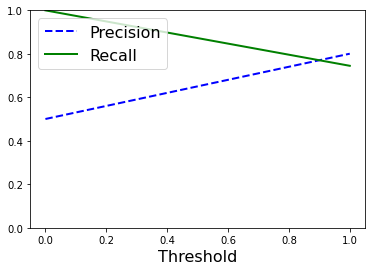

In [26]:
# precision vs recall vs thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

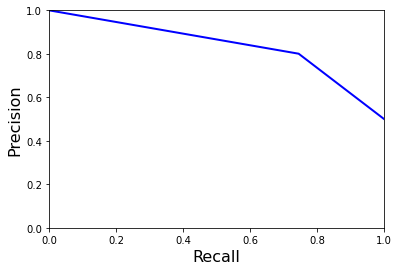

In [27]:
# precision vs recall
plot_precision_vs_recall(precisions, recalls)

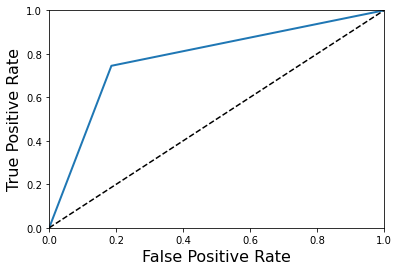

In [28]:
# ROC
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr)

####  Learning Curves

Adapted code from sklearn's [plot_learning_curve example.](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)


In [29]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

@timer
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), 
                        scoring='accuracy'):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        
        Note that for classification the number of samples usually has to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
        
    scoring : string
        Evaluation metric for scores, see model_evaluation for available
        metrics (default='accuracy').
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=scoring,
                       return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label=''.join(["Training ", scoring]))
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label=''.join(["Cross-validation ", scoring]))
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")

    return plt

Elapsed time: 22.4348 seconds
Elapsed time: 22.5631 seconds


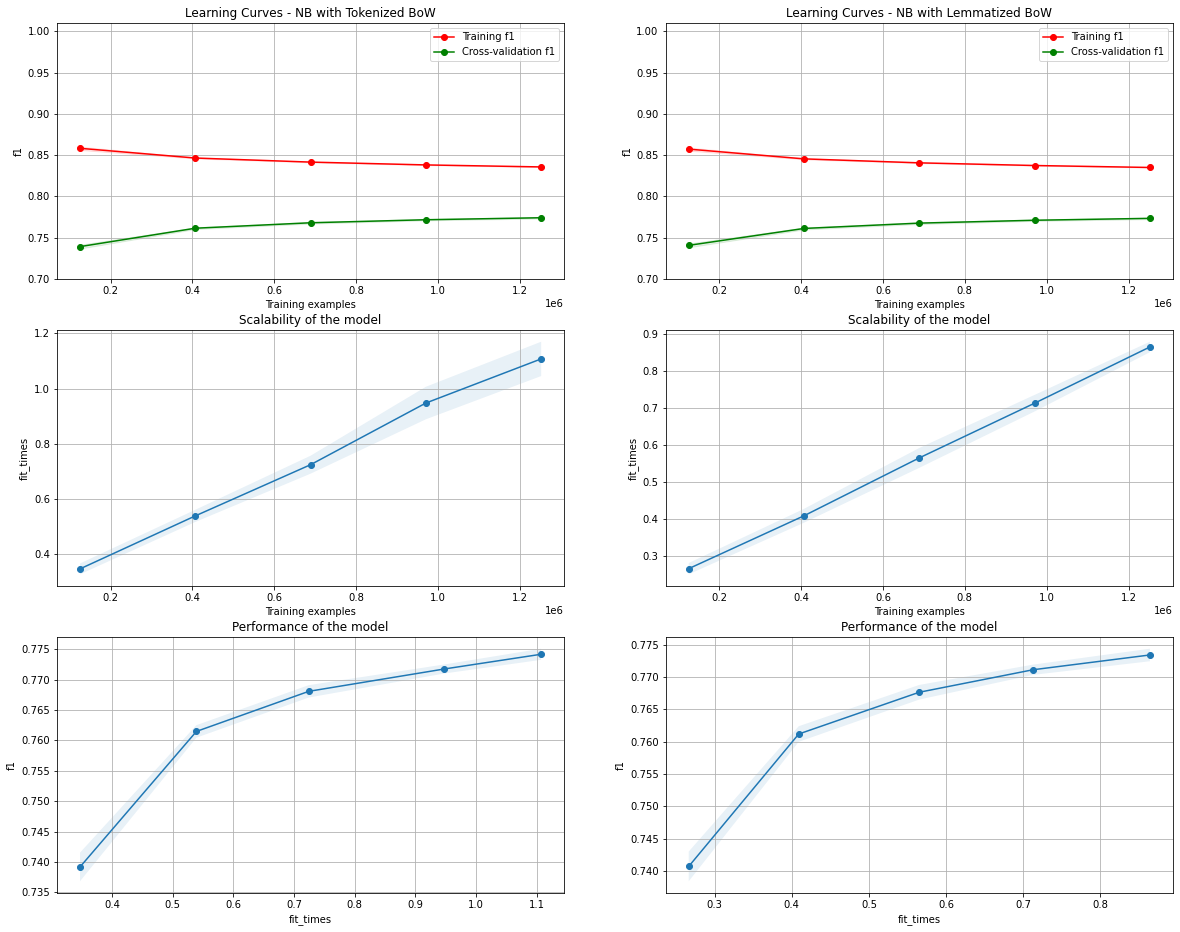

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16))

# Cross validation with n_splits iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = MultinomialNB()

title1 = "Learning Curves - NB with Tokenized BoW"
plot_learning_curve(estimator, title1, X_tokn_bow, y, 
                    axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4, scoring='f1')

title2 = "Learning Curves - NB with Lemmatized BoW"
plot_learning_curve(estimator, title2, X_lemm_bow, y, 
                    axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=3, scoring='f1')
plt.show()

Quick version of the above using accuracy:

In [31]:
@timer
def plot_learning_curves(model, X, y, Xname):
    """Plot the learning curves for train and validation sets:
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_acc, val_acc = [], []

    # plot every 100,000th data point
    data_granularity = 100000
    xs = []
    for m in range(1, X_train.shape[0], data_granularity):        
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        val_acc.append(accuracy_score(y_val, y_val_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, round(X_train.shape[0]/data_granularity, 0), 0.6, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, label="train accuracy")
    plt.plot(xs, np.sqrt(val_acc), 'b--', linewidth=.8, label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", Xname]), fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

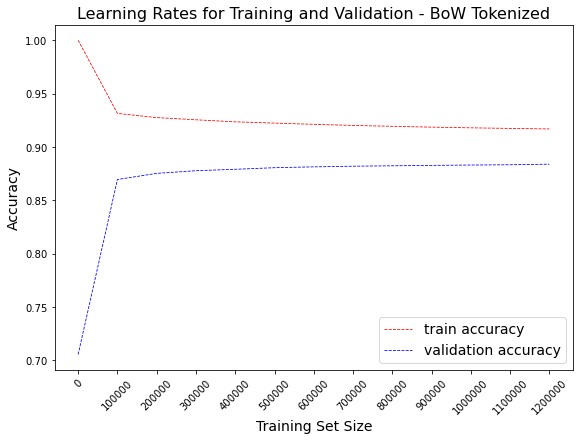

Elapsed time: 8.1995 seconds


In [32]:
plot_learning_curves(NB_clf, X_tokn_bow, y, 'BoW Tokenized')

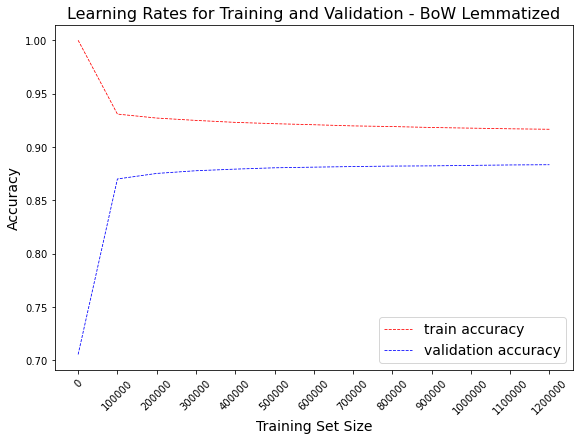

Elapsed time: 7.7623 seconds


In [33]:
plot_learning_curves(NB_clf, X_lemm_bow, y, 'BoW Lemmatized')


As expected, Naive Bayes learns quickly and does not continue to learn given more data. 

---